In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.linalg as linalg
import sklearn.linear_model
import sklearn.model_selection
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs, make_moons
from sklearn.datasets import load_iris
from IPython.display import Markdown as md
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'gensim'

# Applied Machine Learning

## Unsupervised learning: clustering

### Unsupervised learning

- What we have considered so far is all supervised
- The "supervised" name comes from early development of neural networks
- Supervision comes in a form of training data

### Unsupervised learning

- In an unsupervised setting we are only given features, not labels
- We need to make some assumption about the data and state the problem concretely

### Clustering

- Just like classification, but no train labels
- **Classes** of classification become **clusters** of clustering
- Let us consider an example

### Blobs data

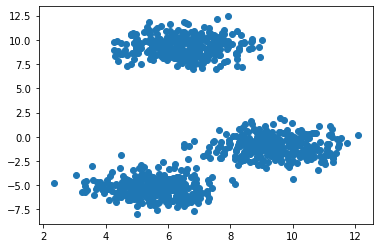

In [3]:
blobs_features, blobs_labels = make_blobs(n_samples=1000, centers=3, random_state=13)
plt.scatter(blobs_features.T[0], blobs_features.T[1]);

### Blobs data: perfect result

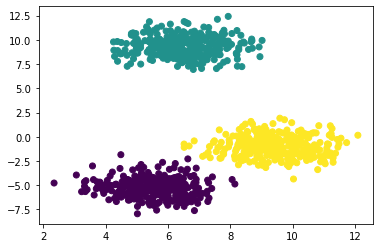

In [4]:
plt.scatter(blobs_features.T[0], blobs_features.T[1], c=blobs_labels);

### Centroid assumption

- Let us assume each cluster has a centroid
- Define centroid as some instance typical for the cluster
- The assumption is just fine if geometry is rather simple

### k-means clustering

- One of the most basic algorithms
- The number of clusters should be known as $k$
- Uses euclidean distance thus needs normalization

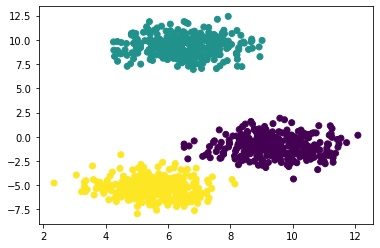

In [5]:
from sklearn.cluster import KMeans
plt.scatter(blobs_features.T[0], blobs_features.T[1], c=KMeans(n_clusters=3).fit_predict(blobs_features));

### k-means algorithm idea

- Initialize $k$ centroid (random for basic k-means, smarter for k-means++)
- Reassign each data point to the nearest centroid
- Recompute each centroid as the mean of all its points
- Repeat previous two steps until convergence

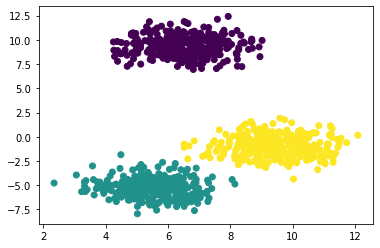

In [6]:
plt.scatter(blobs_features.T[0], blobs_features.T[1], c=KMeans(n_clusters=3).fit_predict(blobs_features));

### Objective function

- K-means provides `score` function that gives a hint how good our clustering is
- The score does not tell how to choose the number of clusters, though

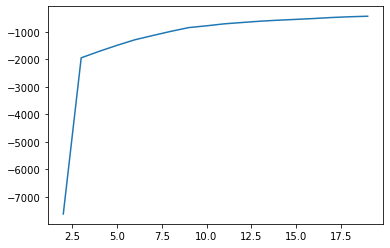

In [7]:
ns = list(range(2, 20, 1))
plt.plot(ns, [KMeans(n_clusters=n).fit(blobs_features).score(blobs_features) for n in ns]);

### The day k-means failed

Once geometry becomes complex k-means is doomed to fail

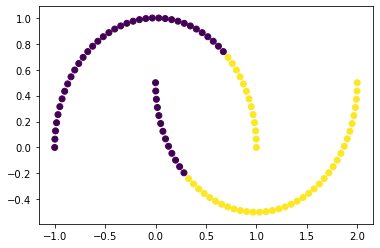

In [8]:
moons_features = make_moons()[0]
plt.scatter(moons_features.T[0], moons_features.T[1], c=KMeans(n_clusters=2).fit_predict(moons_features));

### Anisotropy makes it fail, also

We need another assumption that might make sense

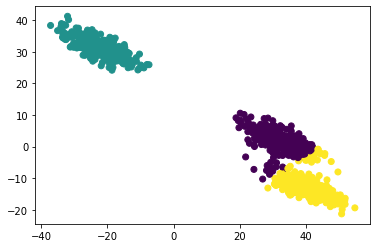

In [9]:
squeeze_me = np.array([[3.0, 0.5], [-4.5, 3.0]])
anisotropic_features = np.dot(blobs_features, squeeze_me)
plt.scatter(anisotropic_features.T[0], anisotropic_features.T[1], 
            c=KMeans(n_clusters=3).fit_predict(anisotropic_features));

### PCA helps though

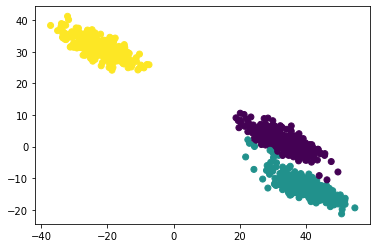

In [10]:
from sklearn.decomposition import PCA
squeeze_me = np.array([[3.0, 0.5], [-4.5, 3.0]])
anisotropic_features = np.dot(blobs_features, squeeze_me)
plt.scatter(anisotropic_features.T[0], anisotropic_features.T[1], 
            c=KMeans(n_clusters=3).fit_predict(PCA(2, whiten=1).fit_transform(anisotropic_features)));

### Connectivity

- The more connected cluster is, the better
- Leads to spectral clustering and hierarchical clustering

### Spectral clustering

Using the neighborhood information we can do much better

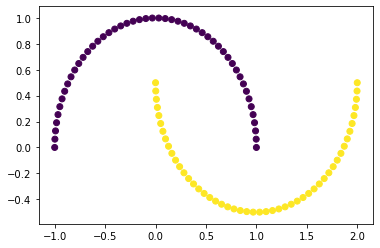

In [11]:
from sklearn.cluster import SpectralClustering
plt.scatter(moons_features.T[0], moons_features.T[1], 
            c=SpectralClustering(n_clusters=2, affinity='nearest_neighbors')\
                    .fit_predict(moons_features));


### Intermezzo: how Google worked when you were really young

### PageRank

- Not a clustering algorithm
- Models random walk
- Find stationary probability of each node

Let's consider some graph 

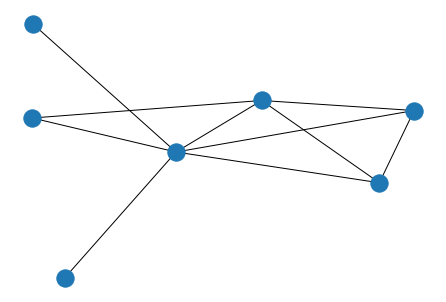

In [12]:
import networkx as nx
G = nx.from_numpy_array(np.array([[1,1,1,1,1,1,1],
                                  [1,1,0,0,0,0,0],
                                  [1,0,1,0,0,0,0],
                                  [1,0,0,1,0,0,1],
                                  [1,0,0,0,1,1,1],
                                  [1,0,0,0,1,1,1],
                                  [1,0,0,1,1,1,1]]))
nx.draw(G)

### Computing PageRank

The algorithm finds score of each node that tells how probable it is to be at it given infinite random walk

In [13]:
nx.pagerank(G)

{0: 0.25009821254801806,
 1: 0.0900839444955169,
 2: 0.0900839444955169,
 3: 0.11343745946600581,
 4: 0.14138530889766263,
 5: 0.14138530889766263,
 6: 0.17352582119961724}

### Clustering graphs

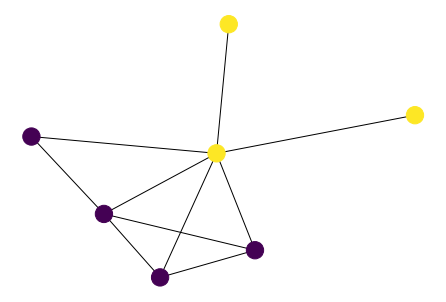

In [22]:
labels = SpectralClustering(2, affinity ="precomputed").fit_predict(nx.adjacency_matrix(G))
nx.draw(G, node_color=labels)

### Idea of spectral clustering

- Just like in PageRank let's consider adjacency matrix
- Let's project our data using eigenvectors of the adjacency matrix
- Things become trivial in this eigenspace

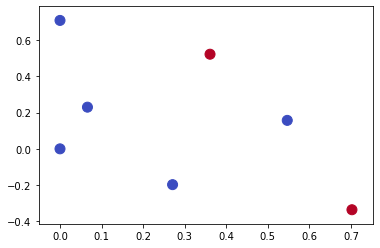

In [18]:
#why not use graph laplacian?
eigenvectors = np.array(np.linalg.eig(nx.adjacency_matrix(G).todense())[1]) #return eigval and eigvec, get eigenvectors.
eigenval = np.array(np.linalg.eig(nx.adjacency_matrix(G).todense())[0])
plt.scatter(eigenvectors[0], eigenvectors[1], c=np.array(labels), cmap='coolwarm', s=100);

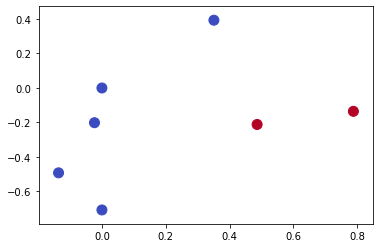

In [21]:
A = nx.adjacency_matrix(G)
D = np.diag(A.sum(axis=1))
L = D-A
eigenvectors = np.array(np.linalg.eig(L)[1]) #return eigval and eigvec, get eigenvectors.
eigenval = np.array(np.linalg.eig(nx.adjacency_matrix(G).todense())[0])
plt.scatter(eigenvectors[0], eigenvectors[1], c=np.array(labels), cmap='coolwarm', s=100);

In [19]:
eigenval

array([ 4.48767160e+00, -1.09445359e+00,  1.69263699e+00, -3.73627341e-01,
        1.28777235e+00,  1.00000000e+00,  4.14574560e-17])

### Noisy data

- Real data is usually noisy and geometry is not that complex
- That's why k-means still work well
- There are some other algorithms although

### DBSCAN

Density-based spatial clustering of applications with noise

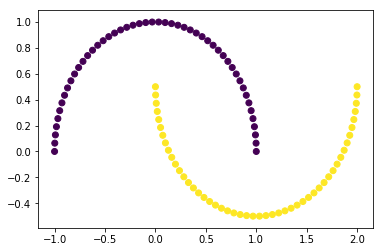

In [15]:
from sklearn.cluster import DBSCAN
plt.scatter(moons_features.T[0], moons_features.T[1], c=DBSCAN().fit_predict(moons_features));

### Making sense out of clustering?????

- Clusters do mean something, but don't overestimate
- Best practice: use clusters as features (???)
- The clusters itself can be categorical features
- The distances to cluster centers can be real-valued features

### Exploratory Data Analysis

- Clustering might be a great tool for EDA
- You can detect something with clustering and visualization 
- The further analysis is usually done manually

### Metrics

- Estimating clustering performance is really hard
- The main reason is that we don't know what we want
- There are some metrics still

### Comparing with the ground truth

- The clustering might be similar up to permutation
- [0, 0, 1, 1] is the same as [1, 1, 0, 0] 
- The Rand index measures that, adjusted Rand is the way to go

### Adjusted Rand index

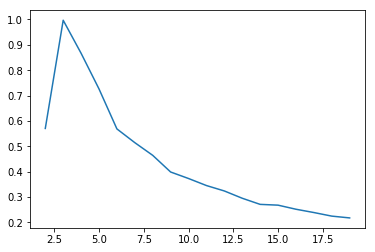

In [16]:
from sklearn.metrics import adjusted_rand_score
plt.plot(ns, [adjusted_rand_score(blobs_labels, KMeans(n_clusters=n).fit_predict(blobs_features)) for n in ns]);

### Silhouette

$$
s = \frac{b-a}{max(a,b)}
$$

- $a$ is the mean distance to samples in same cluster
- $b$ is the mean distance to samples in nearest cluster


### Silhouette of blobs

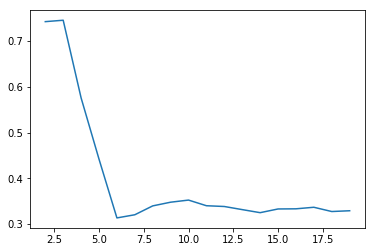

In [17]:
from sklearn.metrics import silhouette_score
plt.plot(ns, [silhouette_score(blobs_features, KMeans(n_clusters=n).fit_predict(blobs_features)) for n in ns]);

### Best metric: confirmation

- It is really good if you can relate your solution to something you know about 
- E.g. you understand the groups of your clients the algorithm found
- It is the only real way to validate your clustering

### Overview

- **k-means:** the simplest and the most scalable algorithm (predictions of neural networks, embeddings)
- **Hierarchical clustering:** gives overview on the whole dataset 
- **DBSCAN:** can detect outliers and work with complex geometry (Kaggle-like, excel-like.., real-world data)
- **Spectral clustering:** can work with graphs and complex geometry (Complex geometry, graphs)